# US Army Corps of Engineers - Using Monte Carlo Simulations to guide decision making

This project was done as part of the course DATA 201 - Data Driven Decision Making (taught by Professor Dan Runfola) in Spring 2018. For this project, we were provided with data on dams across the United States (data source: US Army Corps of Engineers).

The code used here was adapted from the template code provided by Professor Runfola.

# A brief note
While there are several statistical problems associated with the model used (such as: the use of an ordinary least squares regression model, instead of a logistic regression model, to predict a binary variable; not checking for the presence of multicollinearity), they have been ignored for the purposes of illustrating how to conduct a Monta Carlo Simulation to guide decision making. In other words, I'm assuming that an ordinary least square regression is appropriate for predicting binary variables.

# Setting up the workspace

In [1]:
import warnings
warnings.filterwarnings('ignore')
import random
import math
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import scipy
import re
import string
import statsmodels.formula.api
import pylab
from operator import add
import collections
%matplotlib inline
pd.set_option('display.max_columns', 50)

# Assigned Task

Our task was to determine which of the dams were most likely to fail in the future to (hypothetically) assist the US Army Corps of Engineers in determining how to best allocate their resources.

Let's take a look at the data.

# Data

In [2]:
dam = pd.read_csv("Flood_Protection_BL3.csv")

dam.head()

,DID,HIST_YEAR BUILT,HIST_PAST_FAIL_OCCURENCE,8_ERROR_BND,HIST_568_FLOOD_MAGNIFICATION,HIST_568_ERROR_BND,FUTURE_568_FLOOD_MAGNIFICATION,FUTURE_568_ERROR_BND,HIST_566_FLOOD_FREQUENCY,HIST_566_ERROR_BND,FUTURE_566_FLOOD_FREQUENCY,FUTURE_566_ERROR_BND,HIST_244_BASE_FLOW,HIST_244_ERROR_BND,FUTURE_244_BASE_FLOW,FUTURE_244_ERROR_BND,HIST_221_MONTHLY_COV,HIST_221_ERROR_BND,FUTURE_221_MONTHLY_COV,FUTURE_221_ERROR_BND,HIST_570_90PERC_EXCEEDANCE,HIST_570_ERROR_BND,FUTURE_570_90PERC_EXCEEDANCE,FUTURE_570_ERROR_BND,HIST_65_MEAN_ANNUAL_RUNOFF,HIST_65_ERROR_BND,FUTURE_65_MEAN_ANNUAL_RUNOFF,FUTURE_65_ERROR_BND
0,101,1973,1,3.968350,1.188755,0.013232,1.222408,0.086144,28,0,30,9,301.873840,0,222.694499,21.560592,1.578788,0,1.476680,0.045828,6970.063965,0,9093.810472,2284.164063,12134.541990,0,15424.513200,740.632020
1,102,1986,1,4.618573,1.150622,0.004403,1.395499,0.105719,49,0,51,3,544.580933,0,617.395578,28.316043,1.186746,0,1.492583,0.112619,11022.968750,0,11665.529270,725.960912,17147.287110,0,37209.012560,13147.603360
2,103,1983,1,4.001659,1.175774,0.004766,1.483181,0.181301,37,0,38,14,329.885376,0,463.487105,96.594437,1.396369,0,0.744292,0.091713,7725.490234,0,9828.574183,95.038572,11457.014650,0,15575.261310,4537.289882
3,104,1987,0,1.612443,1.080399,0.004054,1.281843,0.175950,59,0,63,2,195.382156,0,290.894438,30.246277,1.408635,0,1.078316,0.033938,4409.598633,0,2402.986813,182.111138,6809.225098,0,7043.237469,162.993012
4,105,1992,1,5.790788,1.283461,0.026428,1.284977,0.192374,44,0,49,4,429.786468,0,624.611584,84.195538,0.900577,0,0.656041,0.202283,7329.574219,0,6863.908858,1517.273808,10806.834960,0,6042.544012,1128.094304


The dataset contains the following information:
1. Historic information on the characteristics of each dam and the associated error
2. Historic information on whether a dam had previously experienced any form of failure
3. Future estimates for the characteristics of each dam and the associated error with each estimate

A table with the description of each variable name is shown below.

![title](metadata.png)

In [3]:
dam.shape

(204, 28)

So there are a total of 204 dams to choose from. For this project, we were tasked with determining which 5 dams deserved the top priority. In other words, which 5 dams out of the 204 dams provided were most likely to fail in the future?

# Method

The probability of each dam’s failure in the future was predicted using a seven-variable ordinary least squares regression model. I first incorporated uncertainty into the historic data and found the parameters of the model that best fit that data. I then introduced uncertainty into the future data. Using the parameters obtained from fitting an ordinary least squares regression model onto the historic data, I predicted each dam’s probability of failure in the future and saved the IDs of the five dams with the highest probability of failure. This entire process was repeated 10,000 times. To account for the uncertainty associated with the variables, the error associated with each of the variables changed with every iteration.

# Steps Taken

## 1. Incorporate uncertainty into the historic and future data
For both historic and future data, uncertainty was incorporated by assuming that the errors associated with each variable are normally distributed. Given the lack of information surrounding the probability distribution of the errors and the wide range of naturally occurring normal distributions, assuming that the errors are normally distributed was the most reasonable option available.

However, it is also possible that error boundaries provided future are not accurate. As such, when specifying the normal distribution, I made it such that 90% of the errors associated with each observation would fall between the error range indicated. In other words, the errors were stipulated to follow a normal distribution of $N$(0, $\frac{error}{1.64}$). (1.64 was obtained as P(Z obtained > 1.64) = 0.05.)

## 2. Determining the criteria for selecting the best model
The criteria that I used for selecting the best model for prediction was the model that generated the lowest Mean Absolute Error (MAE). Under this approach, the MAE of each model was estimated by taking the absolute difference of the model’s predicted probability of a dam failing based on historic data and whether the dam had actually failed in the past. The lower the MAE is, the lower the average error associated with each dam’s predicted probability of failure is, and thus the better the model is. As the full population of dams and their associated data were measured, the lack of statistical assumptions associated with this method does not prevent us from generalizing the results obtained. Furthermore, the ease of interpretation and calculation of the MAE facilitates the justification of resource allocation decisions as policymakers may lack the statistical knowledge required to comprehend alternative methods of determining the model of best fit.

## 3. Obtaining the best model and saving its parameters
The model that was selected involved obtaining the parameters from a multiple linear regression of a dam’s past failure occurrence on its flood magnification, flood frequency, base flow, monthly covariance of flow-squared, 90% exceedance frequency-squared, mean annual runoff, and age-squared (without an intercept). This model was selected as it possessed the lowest MAE that I could find from various combinations of quadratic and linear terms of the variables. The parameters of the model were then saved.

## 4. Using the model to predict the probability of future dam failure
The set of parameters found in Step 3 was applied to the future data (with uncertainty incorporated) to calculate each dam’s predicted probability of future failure. The dams with the five highest predicted probability of failure were saved.

## 5. Repeat Steps 1$-$4 10,000 times
As a result of uncertainty surrounding future estimates, the errors associated with each variable has the potential to change in both magnitude and direction. Consequently, the model of best fit in one iteration will be different from that of another iteration. It is thus possible that a particular iteration generates error values that result in one dam having an anomalously high probability of failure. In other words, the dams with the five highest predicted probability of failure in a single iteration is not necessarily representative of the true probability distribution of dam failure.

As it is statistically unlikely for anomalous error values to be consistently generated over a large number of simulations, simulating 10,000 observations by repeating Steps 1$-$4 yields a better approximation of the probability distribution of dam failure. The IDs of the five dams that were most frequently predicted to be in the group of five dams with the highest probability of failure are thus more likely to be the highest priority dams.

## 6. Robustness checks
Robustness checks to verify the accuracy of the results obtained were conducted by recording the number of times that dams appeared in the top 3$–$7 dams with the highest probability of failure. If it were the case that the same five dams consistently and frequently appeared in the top 3$–$7 dams with the highest probability of failure, that would suggest that the highest priority dams were correctly identified.

# Full Code

In [4]:
#These are the lists which that store the final results.
record_outcomes = [] #This will store the MAE
top_3_dam_ids = []
top_4_dam_ids = []
top_5_dam_ids = []
top_6_dam_ids = []
top_7_dam_ids = []

#Run 10000 iterations
counter = 0
while counter < 10000:
    global dam

    dam = pd.read_csv("Flood_Protection_BL3.csv")
            
    #I created an "AGE" column for the dams
    dam["AGE"] = 2018 - dam["HIST_YEAR BUILT"]

    global sim_dam
    #For each iteration, I created a deep copy of the original dataset.
    sim_dam = dam.copy(deep=True)
    
    #This is how I incorporate uncertainty into the errors such that 90% of the time, it falls within the bounds.
    #To get the bounds, take error / z_crit
    z_crit = scipy.stats.norm.ppf(0.95)
    
    #Generating errors for historical flood magnification. This was the only historical data with error bounds.
    flood_mag_error = []
    for i in range(len(sim_dam)):
        flood_mag_error.append(random.normalvariate(0, sim_dam['HIST_568_ERROR_BND'][i]/z_crit))
    
    #Using list(map(add)). I found that this was one of the most efficient methods for incorporating errors
    sim_dam['HIST_568_FLOOD_MAGNIFICATION'] = pd.Series(list(map(add, \
                                        list(sim_dam['HIST_568_FLOOD_MAGNIFICATION']), flood_mag_error)))

    #Generating the additional variables of interest
    sim_dam["AGE_sq"] = sim_dam["AGE"]**2
    sim_dam["HIST_570_90PERC_EXCEEDANCE_sq"] = sim_dam["HIST_570_90PERC_EXCEEDANCE"]**2
    sim_dam["HIST_221_MONTHLY_COV_sq"] = sim_dam["HIST_221_MONTHLY_COV"]**2
    
    #This is the OLS model that produces the parameters based on historical values (with errors incorporated)
    model = statsmodels.formula.api.ols(formula="HIST_PAST_FAIL_OCCURENCE ~ HIST_568_FLOOD_MAGNIFICATION + \
                                    HIST_566_FLOOD_FREQUENCY + HIST_244_BASE_FLOW + \
                                    HIST_221_MONTHLY_COV_sq + HIST_570_90PERC_EXCEEDANCE_sq + \
                                    HIST_65_MEAN_ANNUAL_RUNOFF + AGE_sq -1", 
                                    data=sim_dam).fit()
    
    #This is how I calculate the MAE of the historical model
    #First, I save the actual historical failure occurrence
    prediction_target = sim_dam['HIST_PAST_FAIL_OCCURENCE']
    
    #I then save the coefficients of the OLS model. I admit that this step is a little unnecessary.
    #But it makes the code easier to understand
    flood_mag_param = model.params[0]
    flood_freq_param = model.params[1]
    base_flow_param = model.params[2]
    monthly_cov_sq_param = model.params[3]
    ninety_perc_sq_param = model.params[4]
    mean_ann_param = model.params[5]
    age_sq_param = model.params[6]
        
    flood_mag_var = sim_dam['HIST_568_FLOOD_MAGNIFICATION'].values
    flood_freq_var = sim_dam['HIST_566_FLOOD_FREQUENCY'].values
    base_flow_var = sim_dam['HIST_244_BASE_FLOW'].values
    monthly_cov_var = sim_dam['HIST_221_MONTHLY_COV'].values
    ninety_perc_var = sim_dam['HIST_570_90PERC_EXCEEDANCE'].values
    mean_ann_var = sim_dam['HIST_65_MEAN_ANNUAL_RUNOFF'].values
    age_var = sim_dam['AGE'].values
        
    #This provides me with a list of the prediction values
    dam_failure_prediction = (flood_mag_var * flood_mag_param) + \
                            (flood_freq_var * flood_freq_param) + \
                            (base_flow_var * base_flow_param) + \
                            (monthly_cov_var**2 * monthly_cov_sq_param) + \
                            (ninety_perc_var**2 * ninety_perc_sq_param) + \
                            (mean_ann_var * mean_ann_param) + \
                            (age_var**2 * age_sq_param)
    
    #This calculates the MAE
    MAE = (1/len(prediction_target)) * math.fsum(abs(prediction_target - dam_failure_prediction))
    
    #Saving the MAE to a list
    record_outcomes.append(MAE)
    
    #I then incorporate the errors for the future data
    fut_flood_mag_error = []
    for i in range(len(sim_dam)):
        fut_flood_mag_error.append(random.normalvariate(0, sim_dam['FUTURE_568_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_568_FLOOD_MAGNIFICATION'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_568_FLOOD_MAGNIFICATION']), fut_flood_mag_error)))

    fut_flood_freq_error = []
    for i in range(len(sim_dam)):
        fut_flood_freq_error.append(random.normalvariate(0, sim_dam['FUTURE_566_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_566_FLOOD_FREQUENCY'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_566_FLOOD_FREQUENCY']), fut_flood_freq_error)))
    
    #I rounded the floor frequency to the nearest whole number because it is only allowed to take on whole numbers
    sim_dam['FUTURE_566_FLOOD_FREQUENCY'] = sim_dam['FUTURE_566_FLOOD_FREQUENCY'].apply(round)
    
    fut_base_flow_error = []
    for i in range(len(sim_dam)):
        fut_base_flow_error.append(random.normalvariate(0, sim_dam['FUTURE_244_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_244_BASE_FLOW'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_244_BASE_FLOW']), fut_base_flow_error)))
    
    fut_month_cov_error = []
    for i in range(len(sim_dam)):
        fut_month_cov_error.append(random.normalvariate(0, sim_dam['FUTURE_221_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_221_MONTHLY_COV'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_221_MONTHLY_COV']), fut_month_cov_error)))
    
    fut_90exceed_error = []
    for i in range(len(sim_dam)):
        fut_90exceed_error.append(random.normalvariate(0, sim_dam['FUTURE_570_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_570_90PERC_EXCEEDANCE'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_570_90PERC_EXCEEDANCE']), fut_90exceed_error)))
    
    fut_mean_ann_error = []
    for i in range(len(sim_dam)):
        fut_mean_ann_error.append(random.normalvariate(0, sim_dam['FUTURE_65_ERROR_BND'][i]/z_crit))
    sim_dam['FUTURE_65_MEAN_ANNUAL_RUNOFF'] = pd.Series(list(map(add, \
                                            list(sim_dam['FUTURE_65_MEAN_ANNUAL_RUNOFF']), fut_mean_ann_error)))
    
    #This is where I calculate the probability of failure for each dam in the future.
    sim_dam["Probability_of_Failure"] = (sim_dam['FUTURE_568_FLOOD_MAGNIFICATION'] * flood_mag_param + \
                      sim_dam['FUTURE_566_FLOOD_FREQUENCY'] * flood_freq_param + \
                      sim_dam['FUTURE_244_BASE_FLOW'] * base_flow_param + \
                      sim_dam['FUTURE_221_MONTHLY_COV']**2 * monthly_cov_sq_param + \
                      sim_dam['FUTURE_570_90PERC_EXCEEDANCE']**2 * ninety_perc_sq_param + \
                      sim_dam['FUTURE_65_MEAN_ANNUAL_RUNOFF'] * mean_ann_param + \
                      sim_dam['AGE']**2 * age_sq_param)
    
    #This was how I did robustness checks
    top_3 = sim_dam.nlargest(3, 'Probability_of_Failure')
    top_4 = sim_dam.nlargest(4, 'Probability_of_Failure')
    top_5 = sim_dam.nlargest(5, 'Probability_of_Failure')
    top_6 = sim_dam.nlargest(6, 'Probability_of_Failure')
    top_7 = sim_dam.nlargest(7, 'Probability_of_Failure')
    
    top_3_dam_ids.append(top_3["DID"].tolist())
    top_4_dam_ids.append(top_4["DID"].tolist())
    top_5_dam_ids.append(top_5["DID"].tolist())
    top_6_dam_ids.append(top_6["DID"].tolist())
    top_7_dam_ids.append(top_7["DID"].tolist())
    counter = counter + 1

# Results & Discussion

The graph below shows how often each dam appeared in the Top 5 Dams with the highest predicted probability of failing in the future.

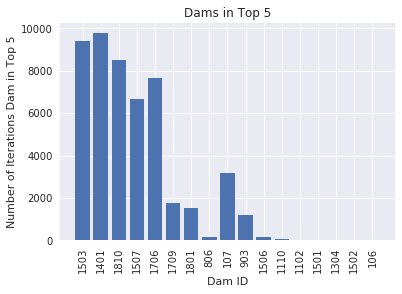

In [5]:
#Obtaining the frequency distribution of the top 5 dams.
flat_top5_list = [item for sublist in top_5_dam_ids for item in sublist]
dam_counts = collections.Counter(flat_top5_list)
plt.bar(range(len(dam_counts)), list(dam_counts.values()), align='center')
plt.xticks(range(len(dam_counts)), list(dam_counts.keys()), rotation="vertical")
plt.ylabel("Number of Iterations Dam in Top 5")
plt.xlabel("Dam ID")
plt.title("Dams in Top 5")
plt.show()

The IDs of the five dams that were most frequently predicted to be in the group of five dams with the highest probability of failure – dams 1401, 1503, 1507, 1706, and 1810 – were identified as possessing the highest risk of failure and are thus of highest priority.

The fact that there are relatively few dam IDs appearing in the Top 5 implies that the uncertainty incorporated into the historic and future data does not have a significant impact on the results.

To get a sense of the accuracy of the model, we can observe the MAE of the historic model.

In [6]:
#Obtaining the MAE
MAEs = pd.Series(record_outcomes)
print(MAEs.mean())

0.3545605093769628


This isn't a particularly great MAE. This means when using historic data to predict the probability of whether or not a dam has failed in the past, our predicted probability of failure is, on average, off by 0.355. Considering that probabilities can only take on values between 0 and 1, it's very likely that our predicted probabilities are very inaccurate.

That said, the results were found to be robust across the top 3 – 7 dams in each iteration. This is evinced from the fact that across the top 3 – 7 dams with the highest probability of failure, the five dams IDs that appeared the most frequently were always the same.

In [7]:
#Obtaining results for Top 5 Dams
top5values = pd.Series(flat_top5_list)
top5values.value_counts()

1401    9772
1503    9391
1810    8488
1706    7670
1507    6646
107     3167
1709    1743
1801    1547
903     1202
1506     153
806      139
1110      39
1102      19
1501      18
1304       4
1502       1
106        1
dtype: int64

In [8]:
#Robustness check - Top 3
flat_top3_list = [item for sublist in top_3_dam_ids for item in sublist]
top3values = pd.Series(flat_top3_list)
top3values.value_counts()

1401    9522
1503    7990
1810    7211
1507    2433
1706    1214
107      659
1709     453
1801     261
903      243
806        7
1506       6
1501       1
dtype: int64

In [9]:
#Robustness check - Top 4
flat_top4_list = [item for sublist in top_4_dam_ids for item in sublist]
top4values = pd.Series(flat_top4_list)
top4values.value_counts()

1401    9666
1503    8897
1810    7966
1507    4913
1706    4321
107     1716
1709    1040
1801     770
903      635
1506      38
806       31
1501       4
1102       2
1110       1
dtype: int64

In [10]:
#Robustness Check - Top 6
flat_top6_list = [item for sublist in top_6_dam_ids for item in sublist]
top6values = pd.Series(flat_top6_list)
top6values.value_counts()

1401    9837
1503    9676
1706    9378
1810    8910
1507    8000
107     4940
1709    2817
1801    2675
903     2196
806      510
1506     487
1110     335
1102     119
1501      93
1304      15
1502       6
106        4
304        2
dtype: int64

In [11]:
#Robustness Check - Top 7
flat_top7_list = [item for sublist in top_7_dam_ids for item in sublist]
top7values = pd.Series(flat_top7_list)
top7values.value_counts()

1401    9893
1706    9869
1503    9829
1810    9221
1507    8846
107     6416
1801    3999
1709    3983
903     3376
1110    1573
806     1204
1506    1067
1102     355
1501     283
1304      40
1502      17
106       15
304       12
1508       1
414        1
dtype: int64

The table below illustrates that the five dam IDs that most frequently appeared in the Top 3$-$7 Dams were always the same.

![title](robustcheck.png)

# Limitations

As mentioned near the start of this post, the purpose of this project was to demonstrate how to conduct a Monte Carlo Simulation to guide decision making. As indicated by the high MAE, using an ordinary least squares regression isn't the best way to predict a binary variable. It is also possible that information on other variables that would have been better predictors of dam failure rates were unavailable.

This method also makes use of a very strong assumption: As the parameters from the ordinary least squares regression obtained from historic data were directly used to calculate the probability of future dam failure, this assumes that the relationship between the variables do not change over time. As such, if it were the case that a particular variable's predictive power changes, the probability of future dam failure calculated using parameters from the ordinary least squares regression would fail to account for this change.

# Final Thoughts

Does this mean that this project was a colossal waste of time? Not necessarily. After all, predicting the future is hard and always involves certain assumptions and limitations. That said, it is imperative that one be transparent about the assumptions and limitations associated with one's analyses such that others can interpret the results within a better context.